# Facial Keypoints Detection

## Initialization

In [1]:
# Load libraries

# OS
import os
import time
from glob import glob
from random import shuffle, seed

# Data manipulation
import numpy as np
import pandas as pd
import cv2
import imgaug
import imgaug.augmenters as iaa
from copy import deepcopy
from sklearn.model_selection import train_test_split

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D

# Modeling
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms, models
from torchsummary import summary
from sklearn import cluster

!nvidia-smi # check if GPU is available
%matplotlib inline

Fri Feb 16 02:18:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda


In [3]:
# Download the dataset
!mkdir data
!cd data && git clone https://github.com/udacity/P1_Facial_Keypoints.git
root_dir = './data/P1_Facial_Keypoints/data/training/'
all_img_paths = glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv('./data/P1_Facial_Keypoints/data/training_frames_keypoints.csv')

mkdir: cannot create directory ‘data’: File exists
Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6049, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 6049 (delta 3), reused 7 (delta 2), pack-reused 6038
Receiving objects: 100% (6049/6049), 329.53 MiB | 15.96 MiB/s, done.
Resolving deltas: 100% (156/156), done.
Updating files: 100% (5805/5805), done.


In [4]:
# Create Dataset class to fetch images and labels
class FacesData(Dataset):
    def __init__(self, df, root_dir):
        super().__init__()
        self.df = df
        self.root_dir = root_dir
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet mean and std

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        img_path = f'{self.root_dir}{self.df.iloc[idx, 0]}'
        image = cv2.imread(img_path)/255.
        keypoints = deepcopy(self.df.iloc[idx,1:].tolist()) # Deep copy to prevent changes in original dataframe
        kp_x = (np.array(keypoints[::2]) / image.shape[1]).tolist() # Pair columns are x coordinates
        kp_y = (np.array(keypoints[1::2])/image.shape[0]).tolist() # Odd columns are y coordinates
        return self.preprocess_input(image), torch.tensor(kp_x + kp_y)

    def preprocess_input(self, image):
        image = cv2.resize(image, (224,224))
        image = torch.tensor(image).permute(2,0,1)
        image = self.normalize(image).float()
        return image.to(device)

    def load_img(self, idx):
        img_path = f'{self.root_dir}{self.df.iloc[idx, 0]}'
        image = cv2.imread(img_path)
        image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)/255.
        return cv2.resize(image, (224,224))

In [5]:
# Split the data into train and test sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=1234)

# Create the datasets
train_ds = FacesData(train_df.reset_index(drop=True), root_dir)
test_ds = FacesData(test_df.reset_index(drop=True), root_dir)

# Define a batch size
batch_size = 32

# Create the dataloaders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [6]:
# Create a function to load the VGG16 model and replace the last layers according to our needs
def load_model():
    model = models.vgg16(weights='IMAGENET1K_V1')
    for param in model.parameters():
        param.requires_grad = False # Freeze all layers
    model.avgpool = nn.Sequential(
        nn.Conv2d(512,512,3),
        nn.MaxPool2d(2),
        nn.Flatten()
    )
    model.classifier = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 136),
        nn.Sigmoid()
    )
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    return model.to(device), criterion, optimizer

In [7]:
# Create a function to train the model on a batch of data
def train_batch(image, keypoints, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    pred_keypoints = model(image.to(device))
    loss = criterion(pred_keypoints, keypoints.to(device))
    loss.backward()
    optimizer.step()
    return loss

In [8]:
# Create a function to validate the model on a batch of data
@torch.no_grad()
def validate_batch(image, keypoints, model, criterion):
    model.eval()
    pred_keypoints = model(image.to(device))
    loss = criterion(pred_keypoints, keypoints.to(device))
    return pred_keypoints, loss

In [9]:
# Train the model
model, criterion, optimizer = load_model()
n_epochs = 50
train_losses, test_losses = [], []

for epoch in range(n_epochs):
    print(f"Epoch {epoch+1} of {n_epochs}")
    epoch_train_loss, epoch_test_loss = 0, 0
    for idx, (image, keypoints) in enumerate(train_dl):
        loss = train_batch(image, keypoints, model, optimizer, criterion)
        epoch_train_loss += loss.item()
    epoch_train_loss /= (idx+1) # Average loss for the epoch on the training set

    for idx, (image, keypoints) in enumerate(test_dl):
        preds, loss = validate_batch(image, keypoints, model, criterion)
        epoch_test_loss += loss.item()
    epoch_test_loss /= (idx+1) # Average loss for the epoch on the test set

    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:23<00:00, 23.1MB/s]


Epoch 1 of 50
Epoch 2 of 50
Epoch 3 of 50
Epoch 4 of 50
Epoch 5 of 50
Epoch 6 of 50
Epoch 7 of 50
Epoch 8 of 50
Epoch 9 of 50
Epoch 10 of 50
Epoch 11 of 50
Epoch 12 of 50
Epoch 13 of 50
Epoch 14 of 50
Epoch 15 of 50
Epoch 16 of 50
Epoch 17 of 50
Epoch 18 of 50
Epoch 19 of 50
Epoch 20 of 50
Epoch 21 of 50
Epoch 22 of 50
Epoch 23 of 50
Epoch 24 of 50
Epoch 25 of 50
Epoch 26 of 50
Epoch 27 of 50
Epoch 28 of 50
Epoch 29 of 50
Epoch 30 of 50
Epoch 31 of 50
Epoch 32 of 50
Epoch 33 of 50
Epoch 34 of 50
Epoch 35 of 50
Epoch 36 of 50
Epoch 37 of 50
Epoch 38 of 50
Epoch 39 of 50
Epoch 40 of 50
Epoch 41 of 50
Epoch 42 of 50
Epoch 43 of 50
Epoch 44 of 50
Epoch 45 of 50
Epoch 46 of 50
Epoch 47 of 50
Epoch 48 of 50
Epoch 49 of 50
Epoch 50 of 50


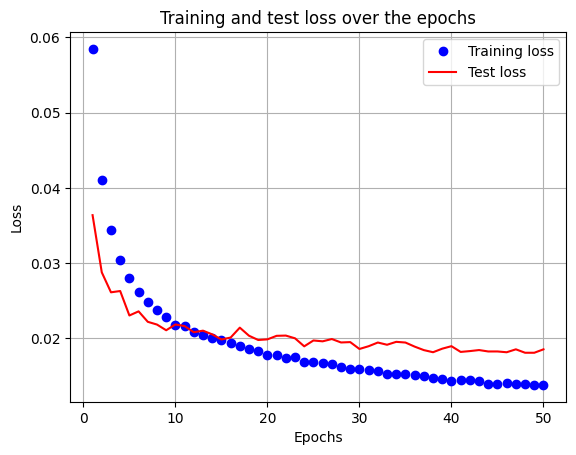

In [10]:
# Plot the training and test losses over the epochs
epochs = range(1, n_epochs+1)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, test_losses, 'r', label='Test loss')
plt.title('Training and test loss over the epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

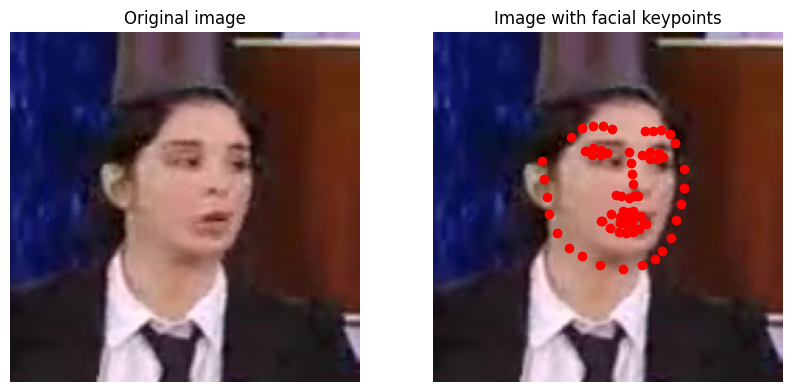

In [16]:
# Test the model on a sample of the test set
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
image = test_ds.load_img(0)
plt.imshow(image)
plt.grid(False)
plt.axis('off')
plt.subplot(222)
plt.title('Image with facial keypoints')
image_tensor, keypoints = test_ds[0]
plt.imshow(image)
pred_keypoints = model(image_tensor[None]).flatten().detach().cpu()
plt.scatter(pred_keypoints[:68]*224, pred_keypoints[68:]*224, c='r') # Scale the keypoints back to the original image size
plt.grid(False)
plt.axis('off')
plt.show()

## 2D and 3D Facial Keypoint detection using a pre-trained model

In [12]:
# Install and import the required extra libraries
!pip install -qU face-alignment torch_snippets
import face_alignment
import plotly.express as px
from torch_snippets import read, show

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 104.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 88.0 MB/s et

In [17]:
# Download a sample image to test the model
!cd data && wget https://t3.ftcdn.net/jpg/02/22/85/16/360_F_222851624_jfoMGbJxwRi5AWGdPgXKSABMnzCQo9RN.jpg -O test.jpg
test_image = read('./data/test.jpg', 1)

--2024-02-16 02:51:37--  https://t3.ftcdn.net/jpg/02/22/85/16/360_F_222851624_jfoMGbJxwRi5AWGdPgXKSABMnzCQo9RN.jpg
Resolving t3.ftcdn.net (t3.ftcdn.net)... 151.101.1.167, 151.101.65.167, 151.101.129.167, ...
Connecting to t3.ftcdn.net (t3.ftcdn.net)|151.101.1.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22868 (22K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  22.33K  --.-KB/s    in 0s      

2024-02-16 02:51:37 (62.1 MB/s) - ‘test.jpg’ saved [22868/22868]



Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth
100%|██████████| 85.7M/85.7M [00:05<00:00, 15.2MB/s]
Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4-cd938726ad.zip
100%|██████████| 91.9M/91.9M [00:07<00:00, 12.1MB/s]


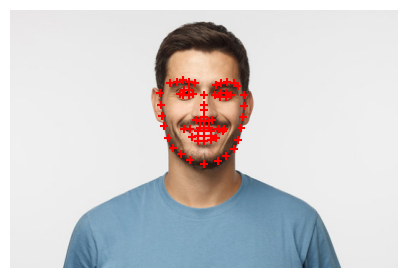

In [20]:
# Set up the face alignment model for 2D detection and make a prediction
fa_2d = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, flip_input=False, device='cpu')
preds = fa_2d.get_landmarks(test_image)[0]

# Plot the image with the facial keypoints
fig, ax = plt.subplots(figsize=(5,5))
show(test_image, ax=ax)
ax.scatter(preds[:,0], preds[:,1], marker='+', c='r')
plt.show()

In [21]:
# Set up the face alignment model for 3D detection and make a prediction
fa_3d = face_alignment.FaceAlignment(face_alignment.LandmarksType.THREE_D, flip_input=False, device='cpu')
preds = fa_3d.get_landmarks(test_image)[0]

# Plot the 3D facial keypoints
df = pd.DataFrame(preds, columns=['x','y','z'])
fig = px.scatter_3d(df, x = 'x', y = 'y', z = 'z')
fig.show()

Downloading: "https://www.adrianbulat.com/downloads/python-fan/3DFAN4-4a694010b9.zip" to /root/.cache/torch/hub/checkpoints/3DFAN4-4a694010b9.zip
100%|██████████| 91.9M/91.9M [00:07<00:00, 13.7MB/s]
Downloading: "https://www.adrianbulat.com/downloads/python-fan/depth-6c4283c0e0.zip" to /root/.cache/torch/hub/checkpoints/depth-6c4283c0e0.zip
100%|██████████| 224M/224M [00:15<00:00, 15.4MB/s]
